In [161]:
import bayesflow as bf
import numpy as np

rng = np.random.default_rng()


In [164]:
# Define hierarchical prior functions

def hierarchical_prior_fun():
    
    hyper_mu = rng.normal(5.00, 1.00)
    hyper_sigma = rng.uniform(0.01, 3.00)

    return np.concatenate([np.r_[hyper_mu, hyper_sigma]])


def local_prior_fun(hyper_theta=hierarchical_prior_fun, n_people = 100):
    mu = rng.normal(hyper_theta[0], hyper_theta[1], size = n_people)
    return mu

prior = bf.simulation.TwoLevelPrior(hyper_prior_fun =  hierarchical_prior_fun, local_prior_fun = local_prior_fun)
prior(batch_size=3)

{'hyper_parameters': array([[5.43418482, 1.74483284],
        [4.68874238, 2.87972578],
        [2.9259352 , 0.91887216]]),
 'local_parameters': array([[ 3.01691159,  6.19155136,  7.75831605,  5.69975793,  8.55910708,
          4.22518073,  5.65961973,  5.89310998,  9.24286811,  3.81612346,
          6.31455587,  3.49160296,  7.60273476,  5.68140163,  5.35666562,
          7.02839409,  4.62990685,  6.6674208 ,  4.9555239 ,  5.78827955,
          3.08250537,  6.77202618,  5.29148245,  8.59333945,  3.11323425,
          4.11053241,  6.19824737,  5.03821757,  6.33799266,  7.11750505,
          7.38525394,  6.13404352,  9.71219991,  4.9521369 ,  8.99573119,
          7.60718298,  5.98225085,  3.98527375,  3.67557346,  4.93272916,
          4.08564355,  4.58854072,  7.52427132,  7.02151561,  2.93714284,
          4.25160846,  3.59251891,  8.37968585,  5.72053703,  4.72619032,
          6.33820616,  3.55577843,  6.66823868,  6.47095957,  6.04030276,
          3.88093206,  4.25808897,  3.2256

In [165]:
# Define hierarchical simulator function

def minimal_hierarchical_simulator(theta, num_obs=20):

    num_participants = theta.shape[0]

    out = np.zeros((num_participants, num_obs))
    for j in range(num_participants): # loop over participants
        for k in range(num_obs): # loop over observations
            out[j, k] = rng.normal(loc=theta[j], scale=1, size=1)
    return out

In [166]:
simulator = bf.simulation.Simulator(simulator_fun=minimal_hierarchical_simulator)
model = bf.simulation.TwoLevelGenerativeModel(prior=prior, simulator=simulator, name="Hierarchical DDM")

/tmp/ipykernel_627/789147584.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[j, k] = rng.normal(loc=theta[j], scale=1, size=1)
INFO:root:Performing 2 pilot runs with the Hierarchical DDM model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 20)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 100)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchabl

In [167]:
model(1)

/tmp/ipykernel_627/789147584.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[j, k] = rng.normal(loc=theta[j], scale=1, size=1)


{'sim_data': array([[[3.63935438, 5.10818094, 5.55376815, ..., 4.87289989,
          5.01671857, 6.4663911 ],
         [4.88436635, 5.70790469, 3.6785192 , ..., 5.5477543 ,
          4.94951501, 4.85125532],
         [4.74851222, 6.4968376 , 4.18617285, ..., 4.68003224,
          6.02856584, 4.56674911],
         ...,
         [4.80041434, 4.41218941, 3.8050064 , ..., 6.68286353,
          6.07350526, 2.49915654],
         [5.42110518, 3.81111615, 3.5059602 , ..., 2.60485933,
          2.72515282, 4.28467818],
         [4.00415913, 4.94603165, 4.57768165, ..., 4.88152592,
          4.04409689, 5.12725993]]]),
 'hyper_prior_draws': array([[5.58972799, 0.4369954 ]]),
 'local_prior_draws': array([[5.99424618, 5.44043617, 5.49777188, 5.87954376, 5.88596375,
         5.72074323, 4.95942523, 4.72755118, 6.49849093, 6.26118041,
         5.66803988, 6.0262609 , 5.2736356 , 5.59715311, 5.03181637,
         5.32732313, 5.26680569, 5.33613176, 5.71553685, 6.69524731,
         5.2254373 , 5.879017

In [168]:
# Define minimal configurator

def configurator(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    # Prepare placeholder dict
    out_dict = {}

    # Extract simulated response times
    out_dict["summary_conditions"] = np.expand_dims(forward_dict["sim_data"], axis=3)

    # Get data generating parameters
    out_dict["local_parameters"] = np.expand_dims(forward_dict["local_prior_draws"].astype(np.float32), axis=2)

    # Get data generating parameters
    out_dict["hyper_parameters"] = forward_dict["hyper_prior_draws"].astype(np.float32)

    return out_dict

In [172]:
# Define networks

summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(summary_dim=10), 
    bf.networks.DeepSet(summary_dim=30)
])

local_inference_net = bf.networks.InvertibleNetwork(
    num_params=1,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="local_ddm_inference"
)

hyper_inference_net = bf.networks.InvertibleNetwork(
    num_params=2,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="hyper_ddm_inference"
)

local_amortizer = bf.amortizers.AmortizedPosterior(local_inference_net, name="local_ddm_amortizer")
hyper_amortizer = bf.amortizers.AmortizedPosterior(hyper_inference_net, name="hyper_ddm_amortizer")
twolevel_amortizer = bf.amortizers.TwoLevelAmortizedPosterior(summary_net = summary_net,
                                                            local_amortizer = local_amortizer,
                                                            global_amortizer = hyper_amortizer)

In [173]:
# Train

trainer = bf.trainers.Trainer(generative_model=model, amortizer=twolevel_amortizer, configurator=configurator)
history = trainer.train_online(epochs=10, iterations_per_epoch=500, batch_size=16, checkpoint_path = "test1")


INFO:root:Performing a consistency check with provided components...
/tmp/ipykernel_627/789147584.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[j, k] = rng.normal(loc=theta[j], scale=1, size=1)
INFO:root:Done.


Training epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/500 [00:00<?, ?it/s]

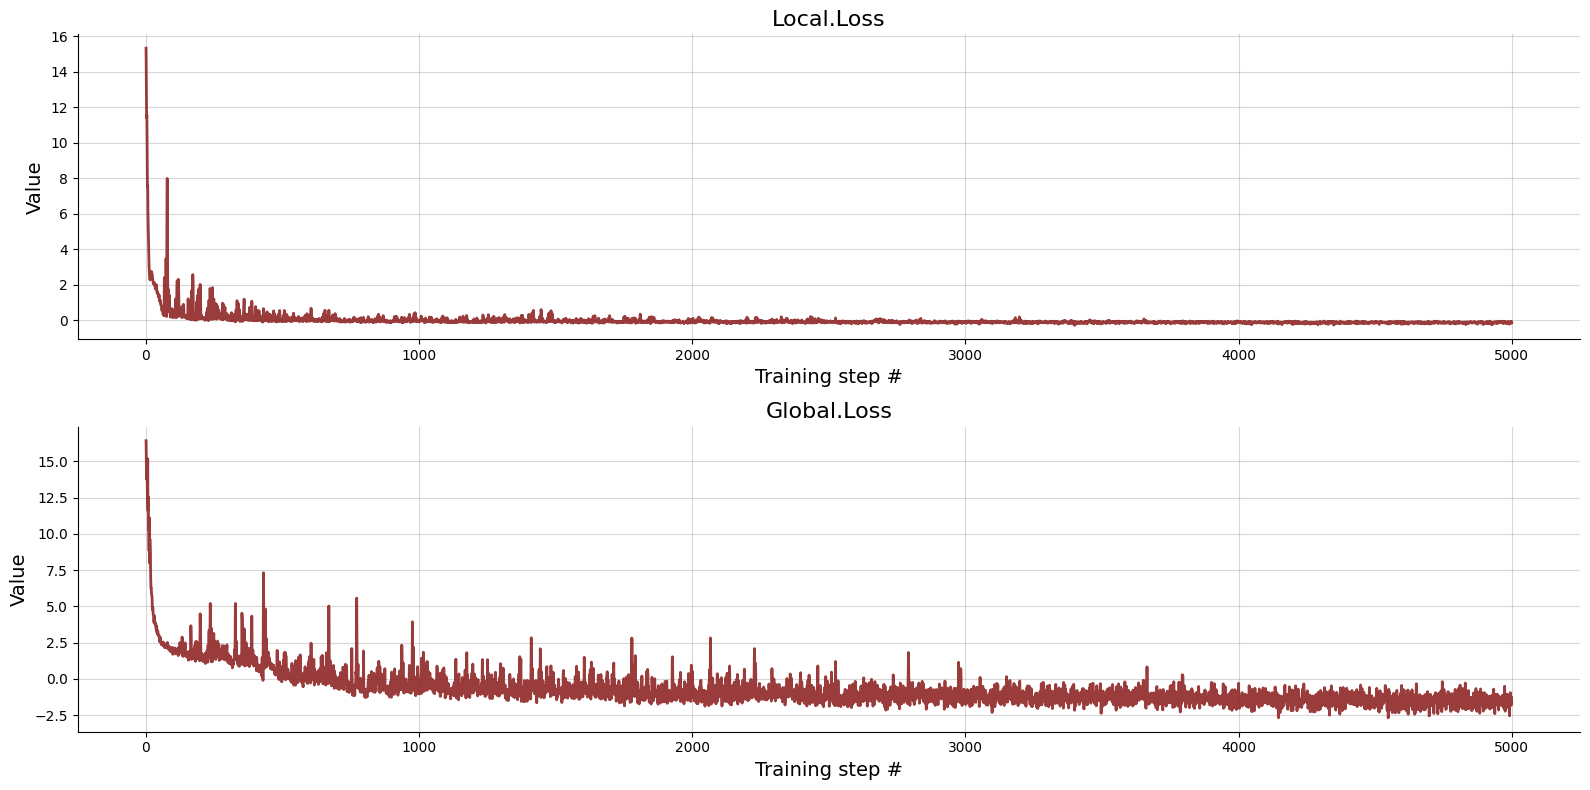

In [174]:
# Plot losses

f = bf.diagnostics.plot_losses(history)

/tmp/ipykernel_627/789147584.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[j, k] = rng.normal(loc=theta[j], scale=1, size=1)


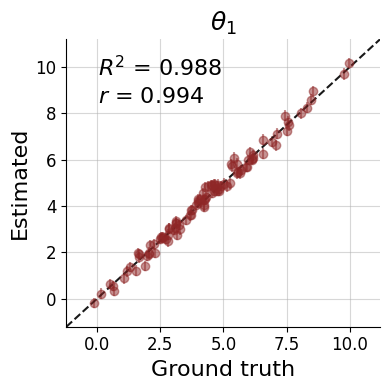

In [180]:
# Plot recovery of local parameters

validation_sims = configurator(model(batch_size=1))
prior_samples = np.squeeze(validation_sims["local_parameters"], axis=0)
post_samples = twolevel_amortizer.sample(validation_sims, n_samples=10000)

f = bf.diagnostics.plot_recovery(
    post_samples["local_samples"],
    prior_samples, point_agg=np.mean, uncertainty_agg=np.std
)

/tmp/ipykernel_627/789147584.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[j, k] = rng.normal(loc=theta[j], scale=1, size=1)


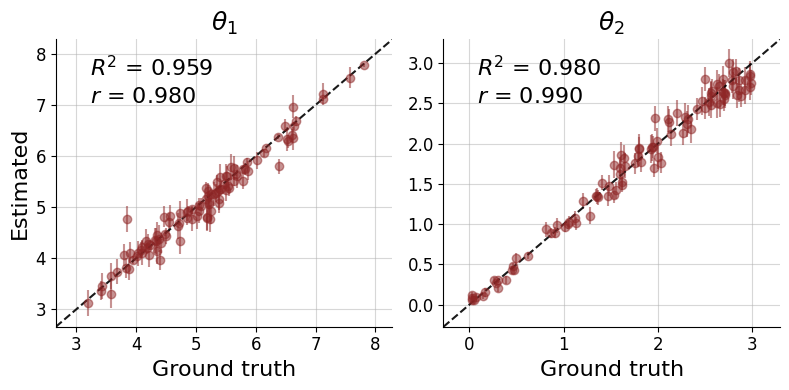

In [181]:
# Plot recovery of hyper parameters
batch_size = 100

prior_samples = validation_sims["hyper_parameters"]
post_samples = np.expand_dims(twolevel_amortizer.sample(validation_sims, n_samples=10000)["global_samples"], axis=0)

for batch in range(batch_size-1):
    validation_sims = configurator(model(1))
    prior_samples = np.concatenate((prior_samples, validation_sims["hyper_parameters"]), axis=0)
    post_samples = np.concatenate((post_samples,
                                   np.expand_dims(twolevel_amortizer.sample(validation_sims, n_samples=10000)["global_samples"], axis=0)), axis=0)

f = bf.diagnostics.plot_recovery(
    post_samples,
    prior_samples, point_agg=np.mean, uncertainty_agg=np.std
)